In [1]:
import altair as alt
import pandas as pd
import numpy as np
from toolz.curried import pipe
import os
from pygbif import species
import geopandas as gpd
import json

import sys
sys.path.append("../../code")
import data_clean
import preprocess_query_family
import preprocess_query_pollen
import preprocess_change_col_type
import altair_data_transformer
from IPython.display import Image

# Create a new data transformer that stores the files in a directory
data_dir = 'altairdata'
altair_data_transformer.setup_altair_for_large_data(data_dir)

In [2]:
tree = pd.read_csv("../../data/processed/public_trees_cleaned.csv", delimiter=",")

small_tree_ranges = ['10-20']
medium_tree_ranges = ['20-30', '30-40']
large_tree_ranges = ['40-50', '50-60', '60-70', '70-80', '80-90', '>90']

size_mapping = {
    'Small': ['10-20'],
    'Medium': ['20-30', '30-40'],
    'Large': ['40-50', '50-60', '60-70', '70-80', '80-90', '>90']
}

# Reverse mapping: height_range -> size_category
height_range_to_size = {
    **{r: 'Small' for r in size_mapping['Small']},
    **{r: 'Medium' for r in size_mapping['Medium']},
    **{r: 'Large' for r in size_mapping['Large']}
}

tree['HEIGHT_SIZE'] = (
    tree['HEIGHT_RANGE']
    .map(height_range_to_size)
    .astype(pd.CategoricalDtype(
        categories=['Small', 'Medium', 'Large'], 
        ordered=True
    )))

tree.head()

,TREE_ID,CIVIC_NUMBER,STD_STREET,GENUS_NAME,SPECIES_NAME,CULTIVAR_NAME,COMMON_NAME,ON_STREET_BLOCK,ON_STREET,NEIGHBOURHOOD_NAME,...,DATE_PLANTED,Geom,geo_point_2d,LATITUDE,LONGITUDE,NOMENCLATURE,ON_ADDRESS,FAMILY_NAME,HAS_POLLEN,HEIGHT_SIZE
0,229002,2128,E 54TH AV,FAGUS,SYLVATICA,DAWYCKII,DAWYCK'S BEECH,2100,E 54TH AV,VICTORIA-FRASERVIEW,...,2014-03-12,"{""coordinates"": [-123.06377300024464, 49.22020...","49.22020099919947, -123.06377300024464",49.220201,-123.063773,FAGUS SYLVATICA,2100 E 54TH AV VICTORIA-FRASERVIEW (EVEN),FAGACEAE,True,Medium
1,229005,8443,FREMLIN ST,ACER,TRUNCATUM,PACIFIC SUNSET,PACIFIC SUNSET MAPLE,8400,FREMLIN ST,MARPOLE,...,2010-11-08,"{""coordinates"": [-123.12751900039063, 49.20967...","49.20967799914094, -123.12751900039063",49.209678,-123.127519,ACER TRUNCATUM,8400 FREMLIN ST MARPOLE (ODD),ACERACEAE,False,Medium
2,229013,1407,W 59TH AV,PRUNUS,CERASIFERA,NIGRA,NIGHT PURPLE LEAF PLUM,7400,CARTIER ST,MARPOLE,...,2010-10-20,"{""coordinates"": [-123.13790199955884, 49.21762...","49.21762499869929, -123.13790199955884",49.217625,-123.137902,PRUNUS CERASIFERA,7400 CARTIER ST MARPOLE (ODD),ROSACEAE,True,Small
3,229015,489,W 2ND AV,PYRUS,CALLERYANA,CHANTICLEER,CHANTICLEER PEAR,400,W 2ND AV,MOUNT PLEASANT,...,2009-12-10,"{""coordinates"": [-123.11410500027938, 49.26698...","49.26698999931175, -123.11410500027938",49.266990,-123.114105,PYRUS CALLERYANA,400 W 2ND AV MOUNT PLEASANT (MED),ROSACEAE,False,Small
4,229016,489,W 2ND AV,PYRUS,CALLERYANA,CHANTICLEER,CHANTICLEER PEAR,400,W 2ND AV,MOUNT PLEASANT,...,2009-12-10,"{""coordinates"": [-123.11399200056373, 49.26704...","49.267045998933334, -123.11399200056373",49.267046,-123.113992,PYRUS CALLERYANA,400 W 2ND AV MOUNT PLEASANT (MED),ROSACEAE,False,Small


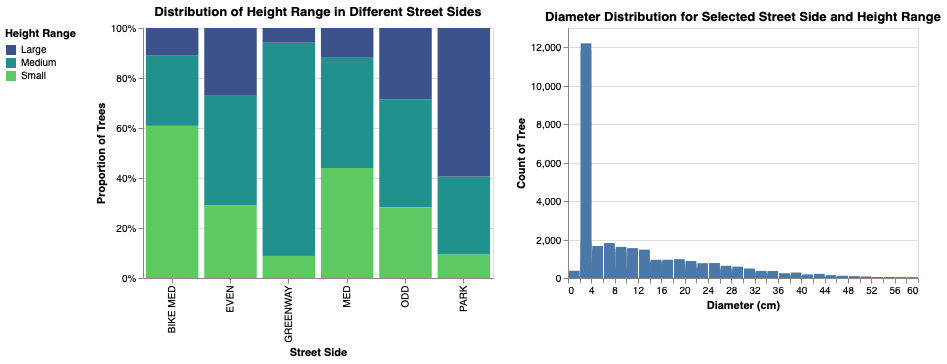

In [3]:
top_20_species = tree['FAMILY_NAME'].value_counts().head(20).index.tolist()

# Filter data for top 20 family species
top_20_tree_species  = tree[tree['FAMILY_NAME'].isin(top_20_species)]

diameter_50 = top_20_tree_species[
    (top_20_tree_species["DIAMETER"] < 60) &
    (top_20_tree_species["DIAMETER"].notna())
]

#Radio Button Selection for Height Category
# height_radio = alt.binding_radio(
#     options=["Small", "Medium", "Large"], name="Height: "
# )

height_radio = alt.binding_radio(
    options=["Show All", "Small", "Medium", "Large"], name="Height: "
)

height_selection = alt.selection_point(
    fields=['HEIGHT_SIZE'],
    bind=height_radio,
    empty=True  # Ensures a default selection
)

#Radio Button Selection for Street Name
# street_radio = alt.binding_radio(
#     options=list(diameter_50['STREET_SIDE_NAME'].unique()), name="Street Side: "
# )

street_radio = alt.binding_radio(
    options=["Show All"] + list(diameter_50['STREET_SIDE_NAME'].unique()), name="Street Side: "
)

street_selection = alt.selection_point(
    fields=['STREET_SIDE_NAME'],
    bind=street_radio,
    empty=True  # Ensures a default selection
)

height_bar = alt.Chart(diameter_50).mark_bar().encode(
    alt.X("STREET_SIDE_NAME:N", title="Street Side"),
    alt.Y("count():Q", stack="normalize", title="Proportion of Trees"),
    alt.Color("HEIGHT_SIZE:N", 
          scale=alt.Scale(scheme="viridis"), 
          title="Height Range",
          legend=alt.Legend(orient="left")),
    opacity=alt.condition(
        height_selection & street_selection,  
        alt.value(1),  # Highlight selected
        alt.value(0.3)  # Dim others
    ),
    tooltip=[
        alt.Tooltip('STREET_SIDE_NAME:N', title='Street Side'),
        alt.Tooltip('HEIGHT_SIZE:N', title='Height Size'),
        alt.Tooltip('count():Q', title='Count of Tree')
    ]
).add_params(height_selection, street_selection).properties(
    title="Distribution of Height Range in Different Street Sides",
    height=250,
    width=350
)

diameter_hist = alt.Chart(diameter_50).mark_bar().encode(
    alt.X("DIAMETER:Q", bin=alt.Bin(maxbins=30), title="Diameter (cm)"),
    alt.Y("count():Q", title="Count of Tree"),
    tooltip=[
        alt.Tooltip('STREET_SIDE_NAME:N', title='Street Side'),
        alt.Tooltip('HEIGHT_SIZE:N', title='Height Size'),
        alt.Tooltip('count():Q', title='Count of Tree'),
        alt.Tooltip('DIAMETER:Q', title='Diameter')
    ]
).transform_filter(
    height_selection & street_selection   # Filters based on selection
).properties(
    title="Diameter Distribution for Selected Street Side and Height Range",
    height=250,
    width=350
)

(height_bar | diameter_hist)

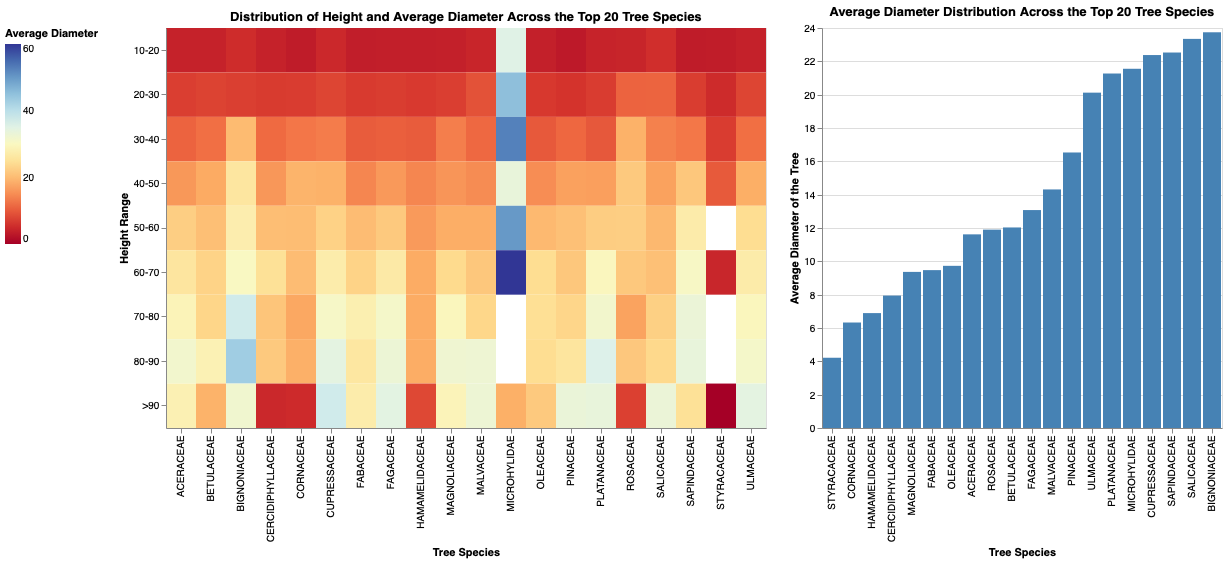

In [4]:
tree_data = top_20_tree_species.groupby(['FAMILY_NAME', 'HEIGHT_RANGE']).agg(
    avg_diameter=('DIAMETER', 'mean'),
    tree_count=('HEIGHT_RANGE', 'size')  # Count all entries in group
).reset_index().dropna()

# Shared Selection for Tree Species (Click)
species_selection = alt.selection_point(fields=['FAMILY_NAME'], name="species_select")

# Hover Effect (Highlight on Hover)
hover_selection = alt.selection_point(fields=['FAMILY_NAME'], name="hover_select", empty="none")

# Heatmap Chart
heatmap = alt.Chart(tree_data).mark_rect().encode(
    alt.X('FAMILY_NAME:N', title='Tree Species'),
    alt.Y('HEIGHT_RANGE:N', title='Height Range'),
    alt.Color('avg_diameter:Q', title='Average Diameter', scale=alt.Scale(scheme='redyellowblue'), legend = alt.Legend(orient="left")),
    opacity=alt.condition(species_selection | hover_selection, alt.value(1), alt.value(0.3)),
    tooltip=[
        alt.Tooltip('FAMILY_NAME:N', title='Species'),
        alt.Tooltip('HEIGHT_RANGE:N', title='Height Range'),
        alt.Tooltip('avg_diameter:Q', title='Avg Diameter', format='.1f'),
        alt.Tooltip('tree_count:Q', title='Tree Count')
    ]
).add_params(species_selection, hover_selection).properties(
    title='Distribution of Height and Average Diameter Across the Top 20 Tree Species',
    width=600,
    height=400
)

avgdia_tree_dist = alt.Chart(top_20_tree_species).mark_bar().encode(
    alt.X("FAMILY_NAME:N", title="Tree Species", sort="y"),
    alt.Y("average(DIAMETER):Q", title="Average Diameter of the Tree", aggregate="mean"),
    opacity=alt.condition(species_selection | hover_selection, alt.value(1), alt.value(0.3)),
    color=alt.condition(hover_selection, alt.value("orange"), alt.value("steelblue")),
    tooltip=['FAMILY_NAME:N', alt.Tooltip('average(DIAMETER):Q', title='Avg Diameter', format='.1f')]
).add_params(species_selection, hover_selection).properties(
    title="Average Diameter Distribution Across the Top 20 Tree Species",
    height=400,
    width=400
)

# Combine Charts
heatmap | avgdia_tree_dist

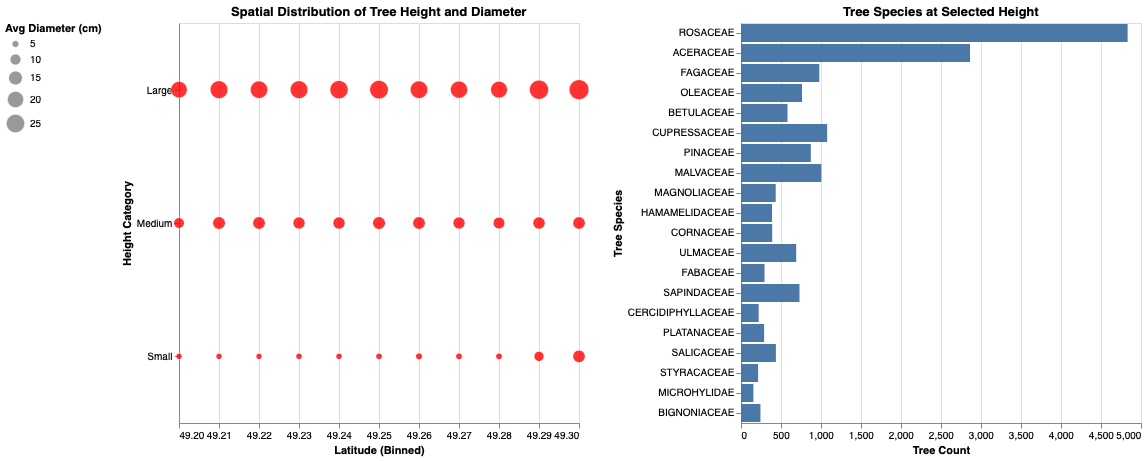

In [30]:
# Selection: Click on a height category (Y-Axis)

height_selection = alt.selection_point(
    fields=['HEIGHT_SIZE'],  
    bind=alt.binding_select(
        options=list(top_20_tree_species['HEIGHT_SIZE'].unique()), 
        name="Select Height: " 
    )
)

dot_selection = alt.selection_point(
    fields=['HEIGHT_SIZE', 'latitude_bin'],
    on='click',
    name="Selected Dot"
)

# Scatter Plot (Latitude vs. Height Category)
scatter = alt.Chart(top_20_tree_species).transform_bin(
    'latitude_bin', 'LATITUDE', bin=alt.Bin(step=0.01)
).transform_aggregate(
    avg_diameter='mean(DIAMETER)',
    count='count()',
    groupby=['HEIGHT_SIZE', 'latitude_bin']
).transform_calculate(
    jitter="sqrt(-2*log(random()))*cos(2*PI*random()) * 0.2"
).mark_circle(
    opacity=0.8,
    stroke='white',
    strokeWidth=0.5
).encode(
    x=alt.X('latitude_bin:Q', title='Latitude (Binned)', scale=alt.Scale(domain=[49.2, 49.3])),
    y=alt.Y('HEIGHT_SIZE:N', title='Height Category', axis=alt.Axis(labelAngle=0)),
    size=alt.Size('avg_diameter:Q', title='Avg Diameter (cm)', scale=alt.Scale(domain=[2, 25]), legend = alt.Legend(orient="left")),
    color=alt.condition(dot_selection, alt.value("red"), alt.value("gray")),  # Highlight selected category
    tooltip=[
        alt.Tooltip('latitude_bin:Q', title='Latitude', format='.4f'),
        alt.Tooltip('HEIGHT_SIZE:N', title='Height Category'),
        alt.Tooltip('avg_diameter:Q', title='Avg Diameter (cm)', format='.1f'),
        alt.Tooltip('count:Q', title='Tree Count')
    ]
).add_params(
    height_selection,
    dot_selection
).properties(
    title="Spatial Distribution of Tree Height and Diameter",
    width=400,
    height=400
)


species_chart = alt.Chart(top_20_tree_species).mark_bar().transform_bin(
    'latitude_bin', 'LATITUDE', bin=alt.Bin(step=0.01)
).encode(
    x=alt.X('count():Q', title="Tree Count"),
    y=alt.Y('FAMILY_NAME:N', title="Tree Species", sort='-x'),
    tooltip=[
        alt.Tooltip('FAMILY_NAME:N', title="Tree Species"),
        alt.Tooltip('HEIGHT_SIZE:N', title="Height Category"),
        alt.Tooltip('mean(DIAMETER):Q', title="Avg Diameter (cm)", format='.1f'),
        alt.Tooltip('count():Q', title="Tree Count"),
        alt.Tooltip('latitude_bin:Q', title='Latitude', format='.4f')
    ]).transform_filter(dot_selection
).transform_filter(height_selection
).properties(
    title="Tree Species at Selected Height",
    width=400,
    height=400
)

linked_view = scatter | species_chart
linked_view